In [2]:
import matplotlib.pyplot as plt
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, sum, count, lit, when,expr
from pyspark.sql.types import StructType, StructField, StringType, TimestampType, BooleanType, DoubleType, IntegerType, DateType

In [3]:
spark = SparkSession.builder.appName("BreweryApp").getOrCreate()
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/06 17:42:48 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [4]:
product_range_path = './craft_beer_bar_sales/Product_range.csv'
transactions_path = './craft_beer_bar_sales/Transactions.csv'

# Product

In [5]:
product_df = spark.read.csv(product_range_path, header=True)
product_df.show(2, truncate = False)

+------------+-----------+-----------------------------------------------+------------+---------+-----------------+-----+---+
|Product_code|Vendor_code|Name                                           |Retail_price|Base_unit|Country_of_Origin|Size |ABV|
+------------+-----------+-----------------------------------------------+------------+---------+-----------------+-----+---+
|5028        |NULL       |1 Symbiotica Apple 0.375                       |300.0       |Pieces   |Russia           |0.375|4.5|
|4846        |NULL       |1 Symbiotica Hard Kombucha Renegade Aronia 0.33|200.0       |Pieces   |Russia           |0.33 |3.0|
+------------+-----------+-----------------------------------------------+------------+---------+-----------------+-----+---+
only showing top 2 rows



In [6]:
product_df.describe().show()

24/01/06 17:43:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


+-------+------------------+-----------+--------------------+-----------------+---------+-----------------+------------------+------------------+
|summary|      Product_code|Vendor_code|                Name|     Retail_price|Base_unit|Country_of_Origin|              Size|               ABV|
+-------+------------------+-----------+--------------------+-----------------+---------+-----------------+------------------+------------------+
|  count|              5314|       4288|                5314|             4878|     4910|             4205|              4626|              4622|
|   mean|2690.8447497177267|       NULL|                NULL|637.8395018450183|     NULL|             NULL|0.6269174232598252|7.0742730419731865|
| stddev|1543.2178144494967|       NULL|                NULL|504.8950056344766|     NULL|             NULL|0.9532897768176336|2.4579696462642713|
|    min|                10|        35K|1 Symbiotica Appl...|              1.0|     100g|              ???|              0.1

In [7]:
for column in product_df.columns:
    col_cnt = product_df.select(column).distinct().count()
    print(f"Count Distinct {column}: {col_cnt}")

Count Distinct Product_code: 5314
Count Distinct Vendor_code: 272
Count Distinct Name: 5193
Count Distinct Retail_price: 185
Count Distinct Base_unit: 5
Count Distinct Country_of_Origin: 29
Count Distinct Size: 32
Count Distinct ABV: 152


In [8]:
not_null_counts = product_df.select([sum((~col(c).isNull()).cast("int")).alias(c) for c in product_df.columns])
not_null_counts.show()

+------------+-----------+----+------------+---------+-----------------+----+----+
|Product_code|Vendor_code|Name|Retail_price|Base_unit|Country_of_Origin|Size| ABV|
+------------+-----------+----+------------+---------+-----------------+----+----+
|        5314|       4288|5314|        4878|     4910|             4205|4626|4622|
+------------+-----------+----+------------+---------+-----------------+----+----+



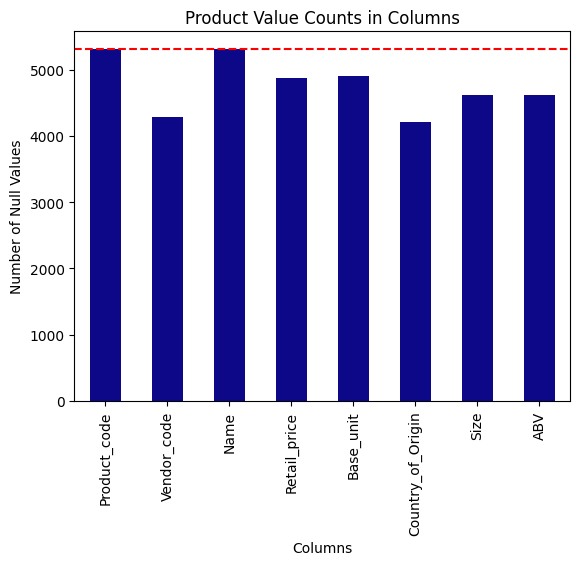

In [9]:
not_null_counts_pandas = not_null_counts.toPandas().transpose()
ax = not_null_counts_pandas.plot(kind="bar", stacked=True, legend=False, colormap="plasma")
plt.title("Product Value Counts in Columns")
plt.xlabel("Columns")
plt.ylabel("Number of Null Values")
plt.axhline(y=product_df.count(), color='red', linestyle='--', label='Upper Limit')
plt.show()

# Transactions

In [10]:
transaction_df = spark.read.csv(transactions_path, header=True)
transaction_df.show(2, truncate = False)

+--------------------------+------------+------+-----------+---------------+------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Amount|Sale_amount|Discount_amount|Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+------+-----------+---------------+------+-----------------+-------------------+
|2020-01-01 23:00:00       |144         |1.0   |280.0      |NULL           |155.0 |124.0            |NULL               |
|2020-01-01 23:00:00       |209         |2.0   |545.73     |294.27         |75.73 |16.11            |35.03              |
+--------------------------+------------+------+-----------+---------------+------+-----------------+-------------------+
only showing top 2 rows



In [11]:
transaction_df.describe().show()

+-------+--------------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|summary|Date_and_time_of_unloading|      Product_code|            Amount|       Sale_amount|   Discount_amount|            Profit| Percentage_markup|Discount_percentage|
+-------+--------------------------+------------------+------------------+------------------+------------------+------------------+------------------+-------------------+
|  count|                     50084|             50084|             50084|             50033|             39882|             50070|             48145|              39882|
|   mean|                      NULL| 2153.160031147672|3.5531462542927743|1429.7866767933122|243.76132290256055| 705.9019868184575|109.18451116419139|  17.25131287297584|
| stddev|                      NULL|1367.3577054997945| 5.485805401475245| 2419.585454701753|  405.902060386317|1352.6286110631174|1182.538753302

In [12]:
for column in transaction_df.columns:
    col_cnt = transaction_df.select(column).distinct().count()
    print(f"Count Distinct {column}: {col_cnt}")

Count Distinct Date_and_time_of_unloading: 458
Count Distinct Product_code: 3956
Count Distinct Amount: 617
Count Distinct Sale_amount: 22573
Count Distinct Discount_amount: 17844
Count Distinct Profit: 27942
Count Distinct Percentage_markup: 13926
Count Distinct Discount_percentage: 3630


In [13]:
not_null_counts = transaction_df.select([sum((~col(c).isNull()).cast("int")).alias(c) for c in transaction_df.columns])
not_null_counts.show()

+--------------------------+------------+------+-----------+---------------+------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Amount|Sale_amount|Discount_amount|Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+------+-----------+---------------+------+-----------------+-------------------+
|                     50084|       50084| 50084|      50033|          39882| 50070|            48145|              39882|
+--------------------------+------------+------+-----------+---------------+------+-----------------+-------------------+



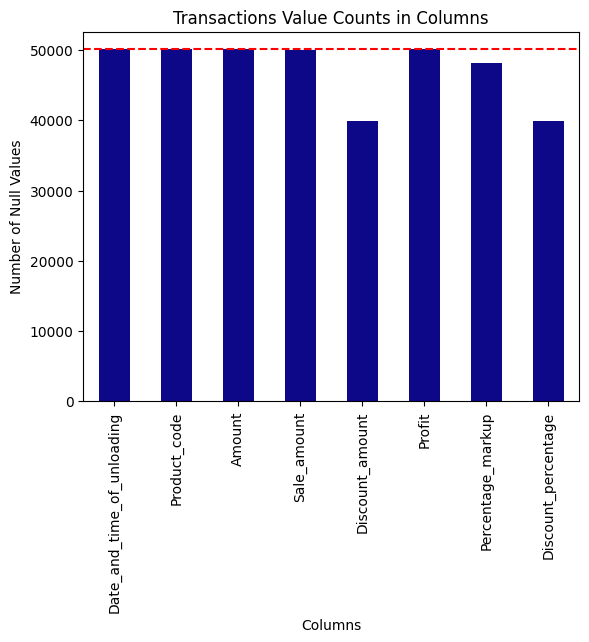

In [14]:
not_null_counts_pandas = not_null_counts.toPandas().transpose()
ax = not_null_counts_pandas.plot(kind="bar", stacked=True, legend=False, colormap="plasma")
plt.title("Transactions Value Counts in Columns")
plt.xlabel("Columns")
plt.ylabel("Number of Null Values")
plt.axhline(y=transaction_df.count(), color='red', linestyle='--', label='Upper Limit')
plt.show()

# Combined DataFrame Sales

In [15]:
sales_df = transaction_df\
    .join(product_df, transaction_df['product_code'] == product_df['Product_code'], how="left")\
        .drop(product_df['Product_code'])\
        .select("Date_and_time_of_unloading",  "Product_code",  "Vendor_code",  "Name",  "Retail_price",  "Base_unit",  "Country_of_Origin",  "Size",  "ABV",  "Amount",  "Sale_amount",  "Discount_amount",  "Profit",  "Percentage_markup",  "Discount_percentage")
sales_df.show(2)

+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+----+------+-----------+---------------+------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Vendor_code|                Name|Retail_price|Base_unit|Country_of_Origin|Size| ABV|Amount|Sale_amount|Discount_amount|Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+----+------+-----------+---------------+------+-----------------+-------------------+
|       2020-01-01 23:00:00|         144|    AF Brew|AF Brew Zimnjaja ...|       280.0|   Pieces|           Russia|0.33|10.3|   1.0|      280.0|           NULL| 155.0|            124.0|               NULL|
|       2020-01-01 23:00:00|         209|    Pohjala|Pohjala Mutant Di...|       420.0|   Pieces|          Estonia|0.33| 6.8|   2.0|     545.73|         294.27| 75.73|         

# Data Cleaning

In [16]:
print("Total Product Rows:", product_df.count())
print("Total Transactions Rows:", transaction_df.count())
print("Total Sales Rows:", sales_df.count())

Total Product Rows: 5314
Total Transactions Rows: 50084
Total Sales Rows: 50084


In [17]:
inactive_product_count = (
    product_df
    .join(
        transaction_df.select("product_code").distinct(),
        on="product_code",
        how="left_anti"
    )
    .count()
)
print(" Total Number of Products:", product_df.count())
print("Inactive List of Products:", inactive_product_count)

 Total Number of Products: 5314
Inactive List of Products: 1358


In [18]:
for column in sales_df.columns:
    col_cnt = sales_df.select(column).distinct().count()
    print(f"Count Distinct {column}: {col_cnt}")

Count Distinct Date_and_time_of_unloading: 458
Count Distinct Product_code: 3956
Count Distinct Vendor_code: 230
Count Distinct Name: 3928
Count Distinct Retail_price: 176
Count Distinct Base_unit: 4
Count Distinct Country_of_Origin: 27
Count Distinct Size: 30
Count Distinct ABV: 144
Count Distinct Amount: 617
Count Distinct Sale_amount: 22573
Count Distinct Discount_amount: 17844
Count Distinct Profit: 27942
Count Distinct Percentage_markup: 13926
Count Distinct Discount_percentage: 3630


## Null Values

In [19]:
not_null_counts = sales_df.select([sum((~col(c).isNull()).cast("int")).alias(c) for c in sales_df.columns])
print("Not Null Count")
not_null_counts.show()

Not Null Count
+--------------------------+------------+-----------+-----+------------+---------+-----------------+-----+-----+------+-----------+---------------+------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Vendor_code| Name|Retail_price|Base_unit|Country_of_Origin| Size|  ABV|Amount|Sale_amount|Discount_amount|Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+-----------+-----+------------+---------+-----------------+-----+-----+------+-----------+---------------+------+-----------------+-------------------+
|                     50084|       50084|      43760|50084|       50081|    50084|            41575|44248|44234| 50084|      50033|          39882| 50070|            48145|              39882|
+--------------------------+------------+-----------+-----+------------+---------+-----------------+-----+-----+------+-----------+---------------+------+-----------------+-------------------+



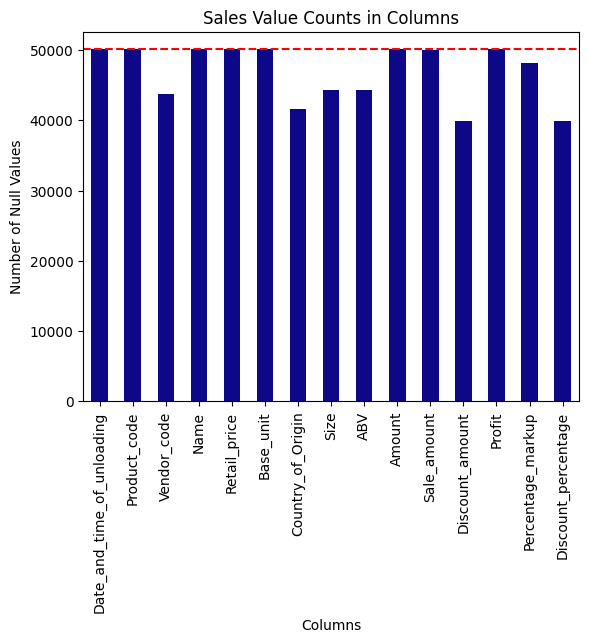

In [20]:
not_null_counts_pandas = not_null_counts.toPandas().transpose()
ax = not_null_counts_pandas.plot(kind="bar", stacked=True, legend=False, colormap="plasma")
plt.title("Sales Value Counts in Columns")
plt.xlabel("Columns")
plt.ylabel("Number of Null Values")
plt.axhline(y=sales_df.count(), color='red', linestyle='--', label='Upper Limit')
plt.show()

In [21]:
total_sales = sales_df.count()
null_percentage_df = sales_df.agg(*[(sum(col(c).isNull().cast("int"))*100 / total_sales).alias(c) for c in sales_df.columns])
null_percentage_pandas = null_percentage_df.toPandas().transpose()
print("Null Percentage")
display(null_percentage_pandas)

Null Percentage


,0
Date_and_time_of_unloading,0.000000
Product_code,0.000000
Vendor_code,12.626787
Name,0.000000
Retail_price,0.005990
Base_unit,0.000000
Country_of_Origin,16.989458
Size,11.652424
ABV,11.680377
Amount,0.000000


In [22]:
null_counts = sales_df.select([sum(col(c).isNull().cast("int")).alias(c) for c in sales_df.columns])
print("Null Value Count")
null_counts.show()

Null Value Count
+--------------------------+------------+-----------+----+------------+---------+-----------------+----+----+------+-----------+---------------+------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Vendor_code|Name|Retail_price|Base_unit|Country_of_Origin|Size| ABV|Amount|Sale_amount|Discount_amount|Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+-----------+----+------------+---------+-----------------+----+----+------+-----------+---------------+------+-----------------+-------------------+
|                         0|           0|       6324|   0|           3|        0|             8509|5836|5850|     0|         51|          10202|    14|             1939|              10202|
+--------------------------+------------+-----------+----+------------+---------+-----------------+----+----+------+-----------+---------------+------+-----------------+-------------------+



In [23]:
print('Sales Product without Retail Price')
sales_df.filter(col('Retail_price').isNull()).select('Product_code', 'Name').show()

Sales Product without Retail Price
+------------+-----------+
|Product_code|       Name|
+------------+-----------+
|        2395|Soft drinks|
|        3046|     Snacks|
|        3046|     Snacks|
+------------+-----------+



In [24]:
print('Name: Snacks')
sales_df.filter(col('Name') == 'Snacks').show(5)
print('Vendor_code: Snacks')
sales_df.filter(col('Vendor_code') == 'Snacks').show(5)

Name: Snacks
+--------------------------+------------+-----------+------+------------+---------+-----------------+----+----+------+-----------+---------------+-------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Vendor_code|  Name|Retail_price|Base_unit|Country_of_Origin|Size| ABV|Amount|Sale_amount|Discount_amount| Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+-----------+------+------------+---------+-----------------+----+----+------+-----------+---------------+-------+-----------------+-------------------+
|       2020-12-01 17:00:00|        3046|       NULL|Snacks|        NULL|   Pieces|             NULL|NULL|NULL|  24.0|    1877.19|         422.81|1877.19|             NULL|              18.38|
|       2020-12-03 19:00:00|        3046|       NULL|Snacks|        NULL|   Pieces|             NULL|NULL|NULL|   8.0|     898.86|         201.14| 898.86|             NULL|              18.29|
+---------------------

In [25]:
print("Vendor_Code Count")
sales_df.groupBy('Vendor_code').count().orderBy('count', ascending = False).show(10)

Vendor_Code Count
+---------------+-----+
|    Vendor_code|count|
+---------------+-----+
|           NULL| 6324|
|           Jaws| 4014|
|        AF Brew| 2756|
|        BrewDog| 2067|
|      Naparbier| 1839|
|        Sobolev| 1507|
|         Snacks| 1241|
|Weihenstephaner| 1197|
|        Bakunin| 1159|
|      Mikkeller| 1103|
+---------------+-----+
only showing top 10 rows



In [26]:
print('Name: Soft drinks')
sales_df.filter(col('Name') == 'Soft drinks').show()

Name: Soft drinks
+--------------------------+------------+-----------+-----------+------------+---------+-----------------+----+----+------+-----------+---------------+--------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Vendor_code|       Name|Retail_price|Base_unit|Country_of_Origin|Size| ABV|Amount|Sale_amount|Discount_amount|  Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+-----------+-----------+------------+---------+-----------------+----+----+------+-----------+---------------+--------+-----------------+-------------------+
|       2020-06-24 19:00:00|        2395|       NULL|Soft drinks|        NULL|   Pieces|             NULL|NULL|NULL|  50.0|   23249.31|           0.69|23249.31|             NULL|                0.0|
+--------------------------+------------+-----------+-----------+------------+---------+-----------------+----+----+------+-----------+---------------+--------+-----------------+--------

In [27]:
# Remove Snacks & Soft Drinks: Vendor_code & Name
sales_df = sales_df.filter(
    (col('Vendor_code') != 'Snacks') | 
    (col('Name') != 'Snacks') 
)
sales_df = sales_df.filter(
    (col('Name') != 'Soft drinks')
)

In [28]:
print('Sales with Vendor_code Null')
sales_df.filter(col('Vendor_code').isNull()).show(5)
print('Sales with Country_of_Origin Null')
sales_df.filter(col('Country_of_Origin').isNull()).show(5)

Sales with Vendor_code Null
+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+---+------+-----------+---------------+------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Vendor_code|                Name|Retail_price|Base_unit|Country_of_Origin|Size|ABV|Amount|Sale_amount|Discount_amount|Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+---+------+-----------+---------------+------+-----------------+-------------------+
|       2020-01-01 23:00:00|        1019|       NULL|Cider Kerisac Bre...|       800.0|   Liters|             NULL| 1.0|5.0|  0.25|      160.0|           20.0| 81.25|           103.17|              11.11|
|       2020-01-01 23:00:00|        1214|       NULL|Trabanco Sidra Na...|       650.0|   Pieces|             NULL| 0.7|6.0|   1.0|     419.66|         

In [29]:
print('Sales with Size Null')
sales_df.filter(col('Size').isNull()).show(5)

Sales with Size Null
+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+----+------+-----------+---------------+------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|Vendor_code|                Name|Retail_price|Base_unit|Country_of_Origin|Size| ABV|Amount|Sale_amount|Discount_amount|Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+----+------+-----------+---------------+------+-----------------+-------------------+
|       2020-01-02 01:00:00|         364|    Sobolev|      Cheese Stilton|       350.0|   Pieces|           Russia|NULL|NULL|   2.0|      629.9|           70.1| 359.9|            133.3|              10.01|
|       2020-01-02 01:00:00|         380|    Sobolev|Cheese Belper Kno...|       300.0|   Pieces|           Russia|NULL|NULL|   1.0|      300.0|           

In [30]:
# Remove Null Values from Vendor_Code & Country_of_Oriigin
sales_df = sales_df.na.fill("Other",["Vendor_code", "Country_of_Origin"]) 

In [31]:
# Unknown Value in Country of Origin
sales_df.filter(col('Country_of_Origin') == "???").show(5)

+--------------------------+------------+------------------+--------------------+------------+---------+-----------------+----+---+------+-----------+---------------+-------+-----------------+-------------------+
|Date_and_time_of_unloading|Product_code|       Vendor_code|                Name|Retail_price|Base_unit|Country_of_Origin|Size|ABV|Amount|Sale_amount|Discount_amount| Profit|Percentage_markup|Discount_percentage|
+--------------------------+------------+------------------+--------------------+------------+---------+-----------------+----+---+------+-----------+---------------+-------+-----------------+-------------------+
|       2020-04-05 18:00:00|        2028|The Garage Brewery|Garage Soup Barrel20|      1120.0|   Liters|              ???| 1.0|6.0|   0.5|      386.1|          133.9|  103.1|            36.43|              25.75|
|       2020-04-05 18:00:00|        2050|The Garage Brewery|   GARAGE Montessori|       570.0|   Pieces|              ???|0.44|6.9|   2.0|     910.4

In [32]:
# Remove Unknown Value in Country of Origin
sales_df = sales_df.withColumn("Country_of_Origin", when(col("Country_of_Origin") == "???", "Other").otherwise(col("Country_of_Origin")))

In [33]:
# Remove unrequired fields
sales_df = sales_df.drop('Percentage_markup', 'Discount_percentage')
sales_df.show(5)

+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+----+------+-----------+---------------+------+
|Date_and_time_of_unloading|Product_code|Vendor_code|                Name|Retail_price|Base_unit|Country_of_Origin|Size| ABV|Amount|Sale_amount|Discount_amount|Profit|
+--------------------------+------------+-----------+--------------------+------------+---------+-----------------+----+----+------+-----------+---------------+------+
|       2020-01-01 23:00:00|         144|    AF Brew|AF Brew Zimnjaja ...|       280.0|   Pieces|           Russia|0.33|10.3|   1.0|      280.0|           NULL| 155.0|
|       2020-01-01 23:00:00|         209|    Pohjala|Pohjala Mutant Di...|       420.0|   Pieces|          Estonia|0.33| 6.8|   2.0|     545.73|         294.27| 75.73|
|       2020-01-01 23:00:00|         213|    Kerisac|Cider Kerisac Cid...|       650.0|   Pieces|           France| 1.0| 6.0|   2.0|    1265.05|          34.95|

In [34]:
# Replacing Null with 0 for Discount
sales_df = sales_df.withColumn("Discount_amount", \
       when(col("Discount_amount").isNull() ,0) \
          .otherwise(col("Discount_amount"))) 

In [35]:
temp_df = sales_df.withColumn('cal_sale', expr("round((Retail_price * Amount)-Discount_amount,2)"))\
    .select('Retail_price', 'Amount', 'Discount_amount', 'Sale_amount', 'cal_sale')
print('Recalculate Sales_Amount')
temp_df.show(2)

Recalculate Sales_Amount
+------------+------+---------------+-----------+--------+
|Retail_price|Amount|Discount_amount|Sale_amount|cal_sale|
+------------+------+---------------+-----------+--------+
|       280.0|   1.0|              0|      280.0|   280.0|
|       420.0|   2.0|         294.27|     545.73|  545.73|
+------------+------+---------------+-----------+--------+
only showing top 2 rows



In [36]:
print('Correct & Incorrect Sales Amount')
print("Correct: ",)
print("Incorrect: ",temp_df.filter(col('Sale_amount')!=col('cal_sale')).count())

Correct & Incorrect Sales Amount
Correct: 
Incorrect:  15757


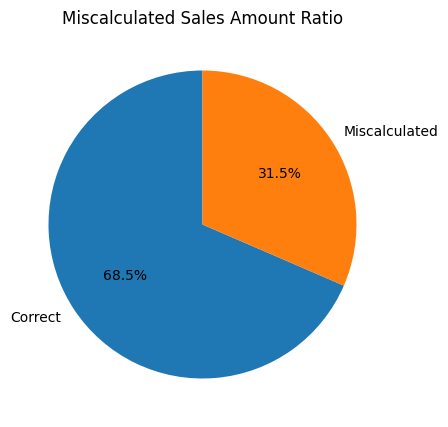

In [37]:
labels = ['Correct', 'Miscalculated']
 
data = [
    temp_df.filter(col('Sale_amount')==col('cal_sale')).count(),
    temp_df.filter(col('Sale_amount')!=col('cal_sale')).count()
]
 
fig = plt.figure(figsize =(8, 5))
plt.pie(data, labels = labels, startangle = 90, autopct='%1.1f%%')

plt.title('Miscalculated Sales Amount Ratio')
 
plt.show()

In [38]:
# Correcting Sale_Amount with Actual Formula
sales_df = sales_df.withColumn('Sale_amount', expr("round((Retail_price * Amount)-Discount_amount,2)"))
sales_df.show(10)

+--------------------------+------------+----------------+--------------------+------------+---------+-----------------+-----+----+------+-----------+---------------+------+
|Date_and_time_of_unloading|Product_code|     Vendor_code|                Name|Retail_price|Base_unit|Country_of_Origin| Size| ABV|Amount|Sale_amount|Discount_amount|Profit|
+--------------------------+------------+----------------+--------------------+------------+---------+-----------------+-----+----+------+-----------+---------------+------+
|       2020-01-01 23:00:00|         144|         AF Brew|AF Brew Zimnjaja ...|       280.0|   Pieces|           Russia| 0.33|10.3|   1.0|      280.0|              0| 155.0|
|       2020-01-01 23:00:00|         209|         Pohjala|Pohjala Mutant Di...|       420.0|   Pieces|          Estonia| 0.33| 6.8|   2.0|     545.73|         294.27| 75.73|
|       2020-01-01 23:00:00|         213|         Kerisac|Cider Kerisac Cid...|       650.0|   Pieces|           France|  1.0| 6.0

## Casting Columns

In [39]:
sales_df = sales_df\
    .withColumn('Entry_date', col('Date_and_time_of_unloading').cast(DateType()))\
    .drop('Date_and_time_of_unloading')

In [40]:
sales_df = sales_df\
    .withColumn('Retail_price', col('Retail_price').cast(DoubleType()))\
    .withColumn('Size', col('Size').cast(DoubleType()))\
    .withColumn('ABV', col('ABV').cast(DoubleType()))\
    .withColumn('Amount', col('Amount').cast(DoubleType()))\
    .withColumn('Sale_amount', col('Sale_amount').cast(DoubleType()))\
    .withColumn('Discount_amount', col('Discount_amount').cast(DoubleType()))\
    .withColumn('Profit', col('Profit').cast(DoubleType()))

In [41]:
for column in sales_df.dtypes:
    print(column[0],column[1])

Product_code string
Vendor_code string
Name string
Retail_price double
Base_unit string
Country_of_Origin string
Size double
ABV double
Amount double
Sale_amount double
Discount_amount double
Profit double
Entry_date date


In [42]:
sales_df.show()

+------------+----------------+--------------------+------------+---------+-----------------+-----+----+------+-----------+---------------+------+----------+
|Product_code|     Vendor_code|                Name|Retail_price|Base_unit|Country_of_Origin| Size| ABV|Amount|Sale_amount|Discount_amount|Profit|Entry_date|
+------------+----------------+--------------------+------------+---------+-----------------+-----+----+------+-----------+---------------+------+----------+
|         144|         AF Brew|AF Brew Zimnjaja ...|       280.0|   Pieces|           Russia| 0.33|10.3|   1.0|      280.0|            0.0| 155.0|2020-01-01|
|         209|         Pohjala|Pohjala Mutant Di...|       420.0|   Pieces|          Estonia| 0.33| 6.8|   2.0|     545.73|         294.27| 75.73|2020-01-01|
|         213|         Kerisac|Cider Kerisac Cid...|       650.0|   Pieces|           France|  1.0| 6.0|   2.0|    1265.05|          34.95|653.05|2020-01-01|
|         217|          Savoie|Cider Savoie Cidr...|

## Rename Columns

In [43]:
sales_df = sales_df.withColumnsRenamed({
    "Product_code": "pid",
    "Vendor_code": "vendor",
    "Name": "product",
    "Retail_price": "retail_price",
    "Base_unit": "base_unit",
    "Country_of_Origin": "origin_country",
    "Size": "size",
    "ABV": "abv",
    "Amount": "quantity",
    "Sale_amount": "total_sale",
    "Discount_amount": "discount",
    "Profit": "profit",
    "Entry_date": "entry_date"
})

In [44]:
# Reorder Columns
columns = sales_df.columns
columns.insert(0, columns.pop())
sales_df = sales_df.select(*columns)

In [45]:
sales_df.show()

+----------+---+----------------+--------------------+------------+---------+--------------+-----+----+--------+----------+--------+------+
|entry_date|pid|          vendor|             product|retail_price|base_unit|origin_country| size| abv|quantity|total_sale|discount|profit|
+----------+---+----------------+--------------------+------------+---------+--------------+-----+----+--------+----------+--------+------+
|2020-01-01|144|         AF Brew|AF Brew Zimnjaja ...|       280.0|   Pieces|        Russia| 0.33|10.3|     1.0|     280.0|     0.0| 155.0|
|2020-01-01|209|         Pohjala|Pohjala Mutant Di...|       420.0|   Pieces|       Estonia| 0.33| 6.8|     2.0|    545.73|  294.27| 75.73|
|2020-01-01|213|         Kerisac|Cider Kerisac Cid...|       650.0|   Pieces|        France|  1.0| 6.0|     2.0|   1265.05|   34.95|653.05|
|2020-01-01|217|          Savoie|Cider Savoie Cidr...|       870.0|   Pieces|        France| 0.75| 4.5|     1.0|     800.0|    70.0| 220.5|
|2020-01-01|222|    

In [46]:
# sales_df.coalesce(1).write.csv("output/sales", header = True)

# Explore

In [47]:
sales_df.createOrReplaceTempView('sales')
spark.sql("select * from sales").show()

+----------+---+----------------+--------------------+------------+---------+--------------+-----+----+--------+----------+--------+------+
|entry_date|pid|          vendor|             product|retail_price|base_unit|origin_country| size| abv|quantity|total_sale|discount|profit|
+----------+---+----------------+--------------------+------------+---------+--------------+-----+----+--------+----------+--------+------+
|2020-01-01|144|         AF Brew|AF Brew Zimnjaja ...|       280.0|   Pieces|        Russia| 0.33|10.3|     1.0|     280.0|     0.0| 155.0|
|2020-01-01|209|         Pohjala|Pohjala Mutant Di...|       420.0|   Pieces|       Estonia| 0.33| 6.8|     2.0|    545.73|  294.27| 75.73|
|2020-01-01|213|         Kerisac|Cider Kerisac Cid...|       650.0|   Pieces|        France|  1.0| 6.0|     2.0|   1265.05|   34.95|653.05|
|2020-01-01|217|          Savoie|Cider Savoie Cidr...|       870.0|   Pieces|        France| 0.75| 4.5|     1.0|     800.0|    70.0| 220.5|
|2020-01-01|222|    

In [48]:
print("Top 10 Profit Product of All Time")
spark.sql("""
SELECT
    pid,
    product,
    round(sum(profit)) total_profit
FROM SALES
GROUP BY 1,2
ORDER BY 3 DESC
LIMIT 10
""").show(truncate = False)

Top 10 Profit Product of All Time
+----+-------------------------------------------------+------------+
|pid |product                                          |total_profit|
+----+-------------------------------------------------+------------+
|717 |Karpachcho                                       |948219.0    |
|2443|Schneider Weisse TAP 7 Majn Orig Barrel          |752042.0    |
|654 |Verhaeghe Barbe Ruby / fruit beer / 7,7%         |627132.0    |
|2392|Jaws Svit Stout Nitro Stout Barrel               |512213.0    |
|1594|Weihenstephaner Original Barrel                  |485100.0    |
|3311|Gaffel Kolsch Barrel30                           |467277.0    |
|519 |Assorted nuts 100 gr                             |457259.0    |
|637 |Weihenstephaner HEFE WEISSBIER / 5,4%            |454351.0    |
|1564|Petrus Aged Red Barrel                           |397882.0    |
|566 |Jaws Atomnaja Prachechnaja / Ipa / 7,2% / 0,5 but|391922.0    |
+----+-------------------------------------------------+

In [49]:
print("Top 5 Loss Product of All Time")
spark.sql("""
SELECT
    pid,
    product,
    round(sum(profit)) total_loss
FROM SALES
WHERE profit < 0
GROUP BY 1,2
ORDER BY 3
LIMIT 5
""").show(truncate = False)

Top 5 Loss Product of All Time
+----+-------------------------------------+----------+
|pid |product                              |total_loss|
+----+-------------------------------------+----------+
|2240|Brekeriet Pink Passion 4,7% Barrel   |-9301.0   |
|1785|Naparbier Oude Gueuze / 6% / 0.75    |-8735.0   |
|1474|Poppels Passion Pale Ale 5.2%        |-7781.0   |
|334 |JAWS / American Pale Ale / APA / 5,5%|-7779.0   |
|333 |JAWS / Oatmeal Stout / stout / 5,2%  |-7000.0   |
+----+-------------------------------------+----------+



In [50]:
print("Top 5 Country By Sales")
spark.sql("""
SELECT
    origin_country,
    CAST(sum(total_sale) AS DECIMAL) total_sale
FROM SALES
WHERE origin_country <> 'Other'
GROUP BY 1
ORDER BY 2 DESC
LIMIT 5
""").show(truncate = False)

Top 5 Country By Sales
+--------------+----------+
|origin_country|total_sale|
+--------------+----------+
|Russia        |30917195  |
|Belgium       |6803146   |
|Germany       |6360224   |
|United Kingdom|3081108   |
|USA           |2542420   |
+--------------+----------+



In [51]:
print("Top 5 Vendor By Sales")
spark.sql("""
SELECT
    vendor,
    CAST(sum(total_sale) AS DECIMAL) total_sale
FROM SALES
WHERE vendor <> "Other"
GROUP BY 1
ORDER BY 2 DESC
LIMIT 5
""").show(truncate = False)

Top 5 Vendor By Sales
+---------------+----------+
|vendor         |total_sale|
+---------------+----------+
|Jaws           |7187389   |
|AF Brew        |3979526   |
|Zagovor        |2983394   |
|Weihenstephaner|2972855   |
|Verhaeghe      |2636706   |
+---------------+----------+



In [52]:
print("Top 10 Discounted Product")
spark.sql("""
SELECT
    pid,
    product,
    round(sum(discount)) total_discount
FROM SALES
GROUP BY 1,2
ORDER BY 3 DESC
LIMIT 10
""").show(truncate = False)

Top 10 Discounted Product
+----+-------------------------------------------------+--------------+
|pid |product                                          |total_discount|
+----+-------------------------------------------------+--------------+
|236 |Verhaeghe Barbe Ruby Fruit Beer / 7.7% / 0.33l   |121138.0      |
|654 |Verhaeghe Barbe Ruby / fruit beer / 7,7%         |120678.0      |
|717 |Karpachcho                                       |96756.0       |
|566 |Jaws Atomnaja Prachechnaja / Ipa / 7,2% / 0,5 but|94921.0       |
|2443|Schneider Weisse TAP 7 Majn Orig Barrel          |71873.0       |
|2098|MELODY Red Button You Me Him Barrel              |66856.0       |
|296 |Jaws American Pale Ale / APA / 5.5% / 0,5 but    |63202.0       |
|3311|Gaffel Kolsch Barrel30                           |62832.0       |
|637 |Weihenstephaner HEFE WEISSBIER / 5,4%            |61611.0       |
|1594|Weihenstephaner Original Barrel                  |54155.0       |
+----+--------------------------------

In [53]:
print("Top 10 Discounted Product with Profit")
spark.sql("""
SELECT
    pid,
    product,
    round(sum(profit)) total_profit,
    round(sum(discount)) total_discount
FROM SALES
WHERE discount IS NOT NULL
GROUP BY 1,2
ORDER BY 4 DESC,3 DESC
LIMIT 10
""").show(truncate = False)

Top 10 Discounted Product with Profit
+----+-------------------------------------------------+------------+--------------+
|pid |product                                          |total_profit|total_discount|
+----+-------------------------------------------------+------------+--------------+
|236 |Verhaeghe Barbe Ruby Fruit Beer / 7.7% / 0.33l   |292142.0    |121138.0      |
|654 |Verhaeghe Barbe Ruby / fruit beer / 7,7%         |627132.0    |120678.0      |
|717 |Karpachcho                                       |948219.0    |96756.0       |
|566 |Jaws Atomnaja Prachechnaja / Ipa / 7,2% / 0,5 but|391922.0    |94921.0       |
|2443|Schneider Weisse TAP 7 Majn Orig Barrel          |752042.0    |71873.0       |
|2098|MELODY Red Button You Me Him Barrel              |203114.0    |66856.0       |
|296 |Jaws American Pale Ale / APA / 5.5% / 0,5 but    |257350.0    |63202.0       |
|3311|Gaffel Kolsch Barrel30                           |467277.0    |62832.0       |
|637 |Weihenstephaner HEFE 

# Clustering
Profitable and Sales Cluster


In [54]:
sales_df.show(5)

+----------+---+-------+--------------------+------------+---------+--------------+----+----+--------+----------+--------+------+
|entry_date|pid| vendor|             product|retail_price|base_unit|origin_country|size| abv|quantity|total_sale|discount|profit|
+----------+---+-------+--------------------+------------+---------+--------------+----+----+--------+----------+--------+------+
|2020-01-01|144|AF Brew|AF Brew Zimnjaja ...|       280.0|   Pieces|        Russia|0.33|10.3|     1.0|     280.0|     0.0| 155.0|
|2020-01-01|209|Pohjala|Pohjala Mutant Di...|       420.0|   Pieces|       Estonia|0.33| 6.8|     2.0|    545.73|  294.27| 75.73|
|2020-01-01|213|Kerisac|Cider Kerisac Cid...|       650.0|   Pieces|        France| 1.0| 6.0|     2.0|   1265.05|   34.95|653.05|
|2020-01-01|217| Savoie|Cider Savoie Cidr...|       870.0|   Pieces|        France|0.75| 4.5|     1.0|     800.0|    70.0| 220.5|
|2020-01-01|222| Bellot|Cider Bellot Cidr...|       770.0|   Pieces|        France|0.75| 5

In [55]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler

In [56]:
beer_data = sales_df\
    .filter(col('profit').isNotNull())\
    .groupBy('product')\
    .agg(sum("total_sale").alias("total_sale"), sum("profit").alias("profit"))

In [57]:
feature_columns = ['total_sale', 'profit']
assembler = VectorAssembler(inputCols = feature_columns, outputCol = 'features')
transformed_data = assembler.transform(beer_data)

In [58]:
kmeans = KMeans( k=4 , seed = 42 , featuresCol = "features")
model = kmeans.fit(transformed_data)

24/01/06 17:43:52 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [59]:
predictions = model.transform(transformed_data)
predictions.show(5)

+--------------------+-----------------+------------------+--------------------+----------+
|             product|       total_sale|            profit|            features|prediction|
+--------------------+-----------------+------------------+--------------------+----------+
|Le Cidre De Foues...|          2549.64|            809.64|    [2549.64,809.64]|         0|
|De Molen Heaven &...|              0.0|            -297.5|        [0.0,-297.5]|         0|
|Lindemans Cassis ...|70047.21999999999|24337.220000000005|[70047.2199999999...|         0|
|Amundsen Apacalyp...|          1479.58|309.58000000000004|[1479.58,309.5800...|         0|
|Jaws Singularity ...|8792.580000000002|           4420.68|[8792.58000000000...|         0|
+--------------------+-----------------+------------------+--------------------+----------+
only showing top 5 rows



In [60]:
predictions_pd = predictions.select("prediction", "total_sale", "profit").toPandas()
predictions_pd

,prediction,total_sale,profit
0,0,2549.64,809.64
1,0,0.00,-297.50
2,0,70047.22,24337.22
3,0,1479.58,309.58
4,0,8792.58,4420.68
...,...,...,...
3920,0,10152.82,4777.82
3921,0,10714.46,4444.46
3922,0,4480.19,1960.19
3923,0,15898.41,7313.61


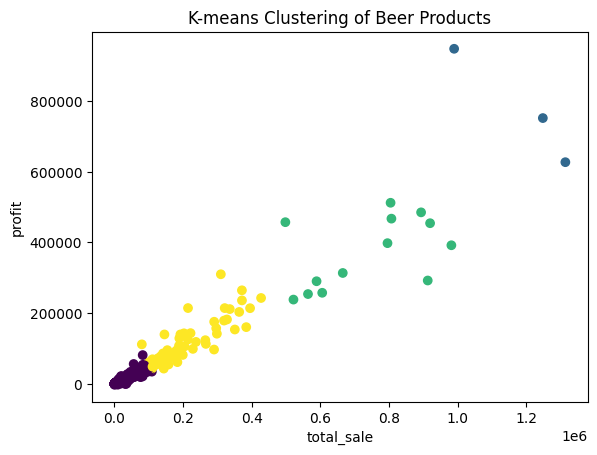

In [61]:
plt.scatter(predictions_pd["total_sale"],predictions_pd["profit"],
           c = predictions_pd["prediction"], cmap = 'viridis' )
plt.xlabel("total_sale")
plt.ylabel("profit")
plt.title("K-means Clustering of Beer Products")
plt.show()

In [62]:
save_df = predictions.drop('features')
# save_df.coalesce(1).write.csv("output/clustering", header = True)

In [63]:
spark.stop()